In [1]:
# Import Libraries

# Image Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Modelling
from sklearn.model_selection import train_test_split

from keras import Model
from keras import applications
from keras.layers import Dense

# Metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Utils
import pandas as pd
import numpy as np
from time import perf_counter
from tensorflow.keras.callbacks import EarlyStopping

# Modelling

## Reading pathways

In [2]:
# read df with label and pathways
df = pd.read_csv('my_dataframe.csv')
df.head()

,label,path
0,A,asl_alphabet_train/asl_alphabet_train\A\A1.jpg
1,A,asl_alphabet_train/asl_alphabet_train\A\A10.jpg
2,A,asl_alphabet_train/asl_alphabet_train\A\A100.jpg
3,A,asl_alphabet_train/asl_alphabet_train\A\A1000.jpg
4,A,asl_alphabet_train/asl_alphabet_train\A\A1001.jpg


## Splitting dataset into train set and test set

In [3]:
# splitting the dataset into training and validating data sets

#splitting into train and test data sets
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)
print(f'train size : {train_df.shape}')
print(f'test size : {test_df.shape}')

train size : (69600, 2)
test size : (17400, 2)


## Image Data Generator

### Parameters

In [4]:
# set image size as the image is a square both sides are the same
img_size = 96

# set x_col and y_cols of df
x_col = 'path'
y_col = 'label'

# set batch size
batch_size = 20

# number of classes = different values of y column
no_of_classes = df[y_col].nunique()

### Sample data set

In [5]:
# creating a smaller sample data set from df
train_df_sample, test_df_sample = train_test_split(df.sample(frac = 0.05), test_size = 0.2, random_state = 42)
print(f'Sample of Training set: {train_df_sample.shape}')
print(f'Sample of Testing set: {test_df_sample.shape}')

Sample of Training set: (3480, 2)
Sample of Testing set: (870, 2)


### Images for Train and Test Set Samples

In [6]:
# image data generator for training set
# setting validation split to 10%
train_datagen = ImageDataGenerator(rescale = 1./img_size, validation_split = 0.1)

# image data generator for test set
test_datagen = ImageDataGenerator(rescale = 1./img_size)

### Creating images for Sample Train set

In [7]:
# training images from sample of train set
train_samples = train_datagen.flow_from_dataframe(
    dataframe = train_df_sample,
    x_col = x_col,
    y_col = y_col,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

# validation images from sample of train set
val_samples = train_datagen.flow_from_dataframe(
    dataframe = train_df_sample,
    x_col = x_col,
    y_col = y_col,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

Found 3132 validated image filenames belonging to 29 classes.
Found 348 validated image filenames belonging to 29 classes.


## Models

### Function to load all the pre-trained models

In [8]:
def load_model(model):
    '''
    Function to load pre-trained CNN models
    '''
    # create base model
    base_model = model(input_shape = (img_size, img_size, 3),
                       include_top = False,
                       weights = 'imagenet',
                       pooling = 'avg'
                      )
    # weights should not be changed for pre-trained models
    base_model.trainable = False
    
    # create output layers, output to classify the number of classes
    x = base_model.output
    x = Dense(128, activation = 'relu')(x)
    x = Dense(128, activation = 'relu')(x)
    outputs = Dense(no_of_classes, activation = 'softmax')(x)
    
    # create model with new input and output layers
    model = Model(inputs = base_model.input, outputs = outputs)
    
    # compile model
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'])
    
    return model

### List of pre trained models

In [9]:
# Dictionary with the models
models = {
    "DenseNet121": {"model": applications.DenseNet121, "perf":0},
    "DenseNet169": {"model": applications.DenseNet169, "perf":0},
    "DenseNet201": {"model": applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model": applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model": applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model": applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model": applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model": applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model": applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model": applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model": applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model": applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model": applications.InceptionV3, "perf":0},
    "MobileNet": {"model": applications.MobileNet, "perf":0},
    "MobileNetV2": {"model": applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model": applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model": applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model": applications.NASNetMobile, "perf":0},
    "ResNet101": {"model": applications.ResNet101, "perf":0},
    "ResNet101V2": {"model": applications.ResNet101V2, "perf":0},
    "ResNet152": {"model": applications.ResNet152, "perf":0},
    "ResNet152V2": {"model": applications.ResNet152V2, "perf":0},
    "ResNet50": {"model": applications.ResNet50, "perf":0},
    "ResNet50V2": {"model": applications.ResNet50V2, "perf":0},
    "VGG16": {"model": applications.VGG16, "perf":0},
    "VGG19": {"model": applications.VGG19, "perf":0},
    "Xception": {"model": applications.Xception, "perf":0}
}

### Testing Sample Training Set

In [10]:
# for names and model in pre-trained models dictionary
for name, model in models.items():
    
    # select pre-trained models
    ptrained_model = load_model(model['model'])
    models[name]['model'] = ptrained_model

    # Train the model
    start = perf_counter()
    history = ptrained_model.fit(train_samples, validation_data = val_samples, epochs = 5, verbose = 0)
    duration = perf_counter() - start

    # Save the training duration and validation accuracy
    models[name]['perf'] = duration
    models[name]['val_acc'] = history.history['val_accuracy']

    # Print the results
    print(f"{name}: trained in {duration:.2f} sec, val_acc = {models[name]['val_acc']}")

DenseNet121: trained in 293.71 sec, val_acc = [0.5833333134651184, 0.7643678188323975, 0.8160919547080994, 0.8477011322975159, 0.8333333134651184]
DenseNet169: trained in 362.91 sec, val_acc = [0.7385057210922241, 0.7988505959510803, 0.8591954112052917, 0.8965517282485962, 0.8994252681732178]
DenseNet201: trained in 517.18 sec, val_acc = [0.7413793206214905, 0.8333333134651184, 0.8678160905838013, 0.8908045887947083, 0.8936781883239746]
EfficientNetB0: trained in 127.68 sec, val_acc = [0.04885057359933853, 0.04022988677024841, 0.03448275849223137, 0.03448275849223137, 0.04597701132297516]
EfficientNetB1: trained in 176.72 sec, val_acc = [0.03448275849223137, 0.06896551698446274, 0.10057470947504044, 0.1350574642419815, 0.12643678486347198]
EfficientNetB2: trained in 191.00 sec, val_acc = [0.08908046036958694, 0.11206896603107452, 0.09482758492231369, 0.13218390941619873, 0.15804597735404968]
EfficientNetB3: trained in 237.80 sec, val_acc = [0.12356321513652802, 0.1982758641242981, 0.22

In [11]:
# Create a DataFrame with the results
models_result = []

# for loop through models
for name, val_acc in models.items():
    # list of val_acc for each epoch
    val_acc_per_epoch = models[name]['val_acc']  
    # create a dictionary with all the required values
    model_dict = {'model': name, 'Training time (sec)': models[name]['perf']}
    # add separate columns for each epoch's validation accuracy
    for i, acc in enumerate(val_acc_per_epoch):
        model_dict[f'val_accuracy_epoch_{i+1}'] = acc
    models_result.append(model_dict)

# create dataframe
df_results = pd.DataFrame(models_result)
df_results.sort_values(by = 'val_accuracy_epoch_5', ascending = False, inplace = True)
df_results.reset_index(inplace = True, drop = True)
df_results

,model,Training time (sec),val_accuracy_epoch_1,val_accuracy_epoch_2,val_accuracy_epoch_3,val_accuracy_epoch_4,val_accuracy_epoch_5
0,MobileNet,64.179955,0.758621,0.824713,0.853448,0.887931,0.925287
1,MobileNetV2,68.853669,0.807471,0.864943,0.870690,0.887931,0.919540
2,DenseNet169,362.913588,0.738506,0.798851,0.859195,0.896552,0.899425
3,DenseNet201,517.176190,0.741379,0.833333,0.867816,0.890805,0.893678
4,VGG16,289.762548,0.497126,0.658046,0.712644,0.770115,0.836207
5,DenseNet121,293.709247,0.583333,0.764368,0.816092,0.847701,0.833333
6,VGG19,355.113544,0.399425,0.617816,0.724138,0.775862,0.804598
7,ResNet101V2,340.578989,0.508621,0.637931,0.712644,0.698276,0.775862
8,Xception,190.847796,0.491379,0.672414,0.735632,0.758621,0.770115
9,ResNet50V2,199.536090,0.531609,0.658046,0.704023,0.767241,0.752874


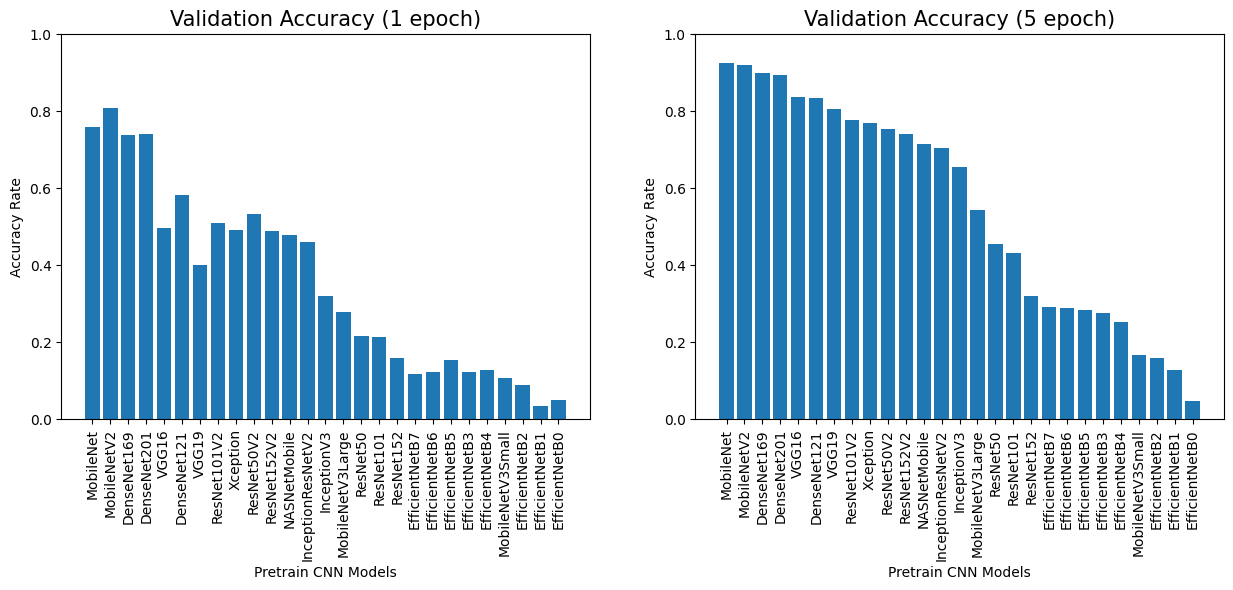

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot graph of validation accuracy
axs[0].bar(x = 'model', height = 'val_accuracy_epoch_1', data = df_results)

# labels
axs[0].set_title('Validation Accuracy (1 epoch)', fontsize = 15)
axs[0].set_xlabel('Pretrain CNN Models')
axs[0].set_ylabel('Accuracy Rate')
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis = 'x', rotation = 90)

# plot graph of time taken
axs[1].bar(x = 'model', height = 'val_accuracy_epoch_5', data = df_results)

# labels
axs[1].set_title('Validation Accuracy (5 epoch)', fontsize = 15)
axs[1].set_xlabel('Pretrain CNN Models')
axs[1].set_ylabel('Accuracy Rate')
axs[1].set_ylim(0, 1)
axs[1].tick_params(axis = 'x', rotation = 90)

# save plot
#plt.savefig('sample_val_acc.png')

plt.show()

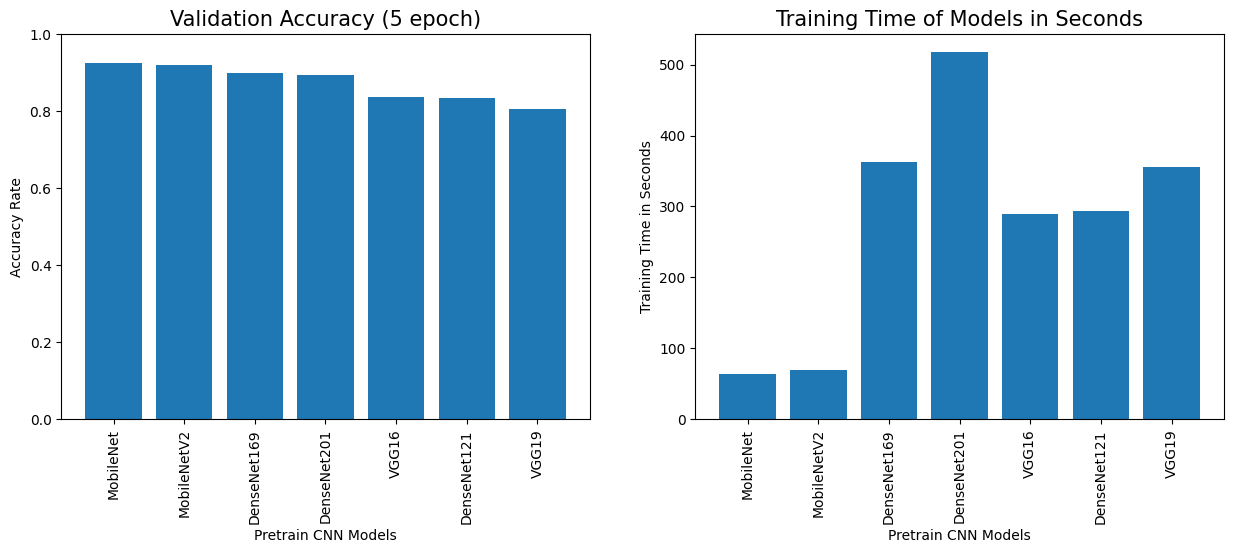

In [13]:
# filter the DataFrame to include only rows where val_accuracy_epoch_5 is > 0.8
filtered_df = df_results[df_results['val_accuracy_epoch_5'] > 0.8]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot graph of validation accuracy
axs[0].bar(x = 'model', height = 'val_accuracy_epoch_5', data = filtered_df)

# labels
axs[0].set_title('Validation Accuracy (5 epoch)', fontsize=15)
axs[0].set_xlabel('Pretrain CNN Models')
axs[0].set_ylabel('Accuracy Rate')
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis = 'x', rotation = 90)

# plot graph of time taken
axs[1].bar(x = 'model', height = 'Training time (sec)', data = filtered_df)

# labels
axs[1].set_title('Training Time of Models in Seconds', fontsize = 15)
axs[1].set_xlabel('Pretrain CNN Models')
axs[1].set_ylabel('Training Time in Seconds')
axs[1].tick_params(axis = 'x', rotation = 90)

# save plot
#plt.savefig('top_models.png')

plt.show()

### Testing with all data

In [14]:
# train images
train_images = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = x_col,
    y_col = y_col,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = 0,
    subset = 'training'
)

# validation images
val_images = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = x_col,
    y_col = y_col,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = 0,
    subset = 'validation'
)

# test images
test_images = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = x_col,
    y_col = y_col,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 6960 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [15]:
# Get the model name with the highest validation score
best_model_name = df_results.iloc[0]['model']

# return model with keras.application and name of best model
best_model = getattr(applications, best_model_name)
print(best_model)

<function MobileNet at 0x000001DFBCF45C60>


In [16]:
# Create model
model = load_model(best_model)


# early stopping; set to val_loss for overfitting
stop_early = EarlyStopping(monitor = 'val_loss',
                           patience = 2,
                           restore_best_weights = True)

# Train the model
history = model.fit(train_images,
                    validation_data = val_images,
                    epochs = 10,
                    callbacks = [stop_early]
                    )

Epoch 1/10
3132/3132 [==============================] - 790s 252ms/step - loss: 0.2523 - accuracy: 0.9216 - val_loss: 0.0917 - val_accuracy: 0.9671
Epoch 2/10
3132/3132 [==============================] - 267s 85ms/step - loss: 0.0732 - accuracy: 0.9758 - val_loss: 0.1060 - val_accuracy: 0.9680
Epoch 3/10
3132/3132 [==============================] - 267s 85ms/step - loss: 0.0583 - accuracy: 0.9810 - val_loss: 0.0398 - val_accuracy: 0.9848
Epoch 4/10
3132/3132 [==============================] - 272s 87ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.0687 - val_accuracy: 0.9825
Epoch 5/10
3132/3132 [==============================] - 267s 85ms/step - loss: 0.0432 - accuracy: 0.9872 - val_loss: 0.0448 - val_accuracy: 0.9842


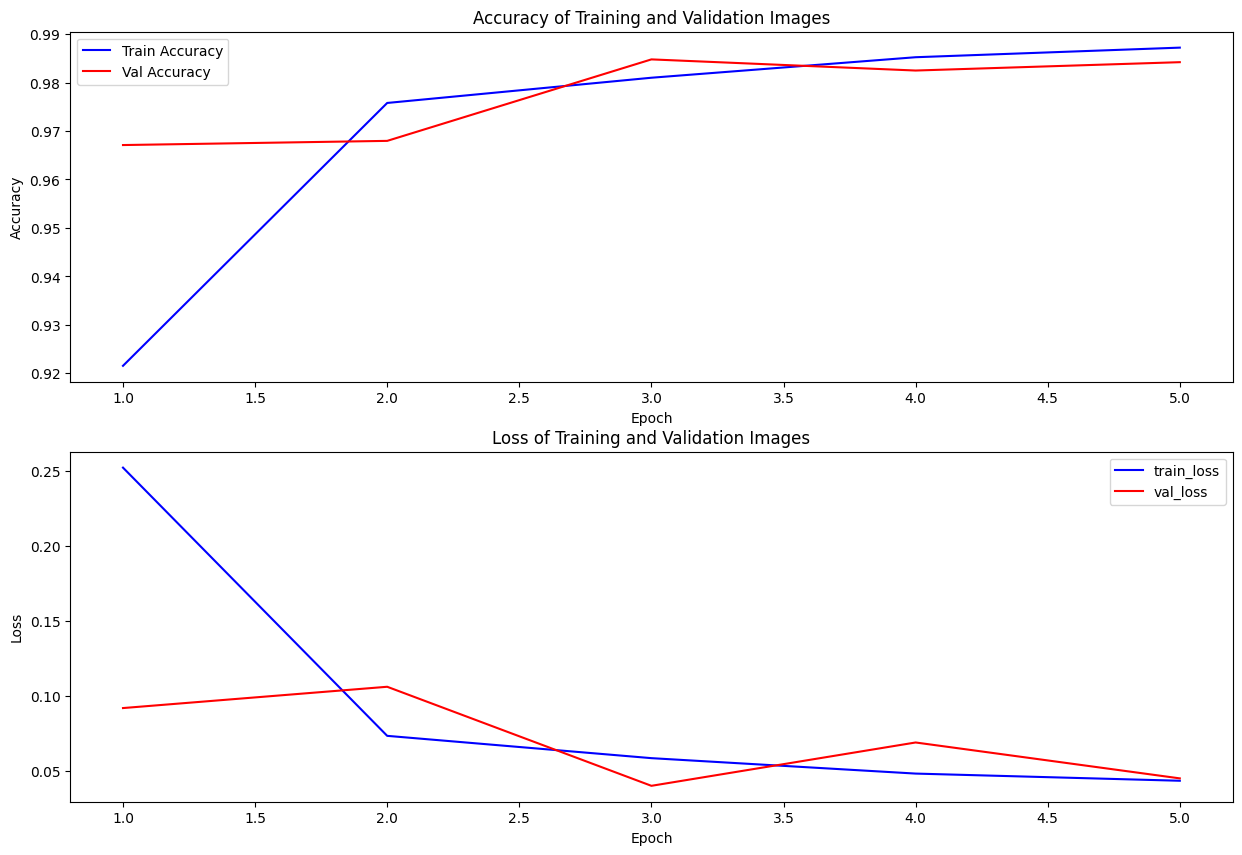

In [17]:
# set variables
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# set subplot
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
ax = axs.flatten()

# plot the accuracy
ax[0].plot(epochs, accuracy, color = 'blue', label = 'Train Accuracy')
ax[0].plot(epochs, val_accuracy, color = 'red', label = 'Val Accuracy')
ax[0].set_title('Accuracy of Training and Validation Images')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# plot the loss
ax[1].plot(epochs, loss, color = 'blue', label = 'train_loss')
ax[1].plot(epochs, val_loss, color = 'red', label='val_loss')
ax[1].set_title('Loss of Training and Validation Images')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# save the plot as an image file
#plt.savefig('accuracy and loss.png')

plt.show()

In [18]:
# Generate predictions for test set
y_pred = model.predict(test_images)

# Convert predictions from probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Get true labels for test set
y_true = test_images.labels

# Generate classification report
print(classification_report(y_true, y_pred))

870/870 [==============================] - 210s 241ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       584
           1       1.00      0.98      0.99       574
           2       1.00      0.99      0.99       617
           3       1.00      0.99      0.99       589
           4       0.96      1.00      0.98       580
           5       1.00      0.99      0.99       585
           6       1.00      0.97      0.98       587
           7       0.97      1.00      0.99       599
           8       0.99      0.99      0.99       598
           9       1.00      1.00      1.00       610
          10       0.98      0.99      0.99       609
          11       0.98      1.00      0.99       641
          12       0.99      1.00      0.99       626
          13       0.99      0.99      0.99       587
          14       1.00      0.99      1.00       569
          15       1.00      1.00      1.00       603
          16       1.0

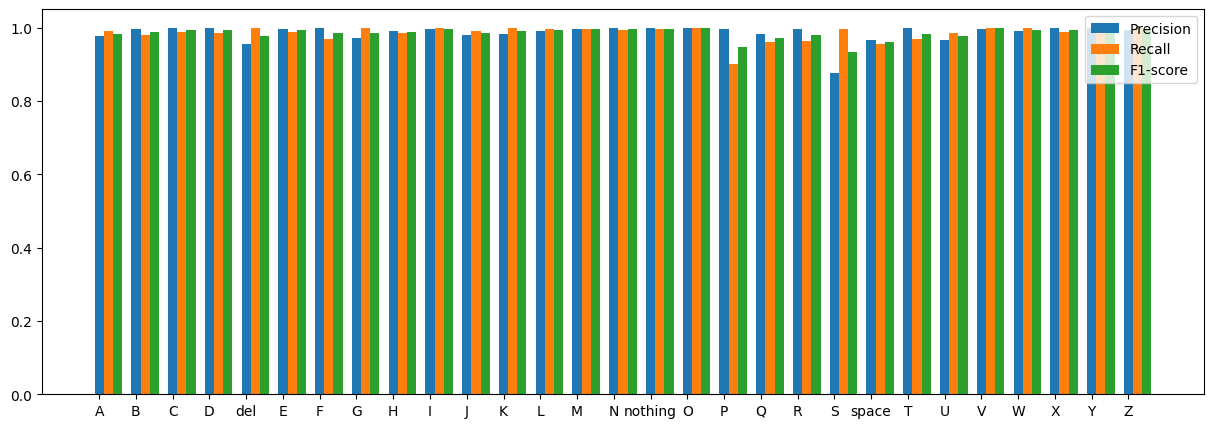

In [19]:
class_names = df['label'].unique()
report = classification_report(y_true, y_pred, target_names = class_names, output_dict = True)

# Extract the required values
precision = [report[label]['precision'] for label in class_names]
recall = [report[label]['recall'] for label in class_names]
f1_score = [report[label]['f1-score'] for label in class_names]

# Create a grouped bar chart
x = range(len(class_names))
fig, ax = plt.subplots(figsize = (15, 5))
ax.bar(x, precision, width=0.25, label='Precision')
ax.bar([i+0.25 for i in x], recall, width=0.25, label='Recall')
ax.bar([i+0.5 for i in x], f1_score, width=0.25, label='F1-score')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
plt.show()

Best Model: MobileNet with 98.53% accuracy on the test set


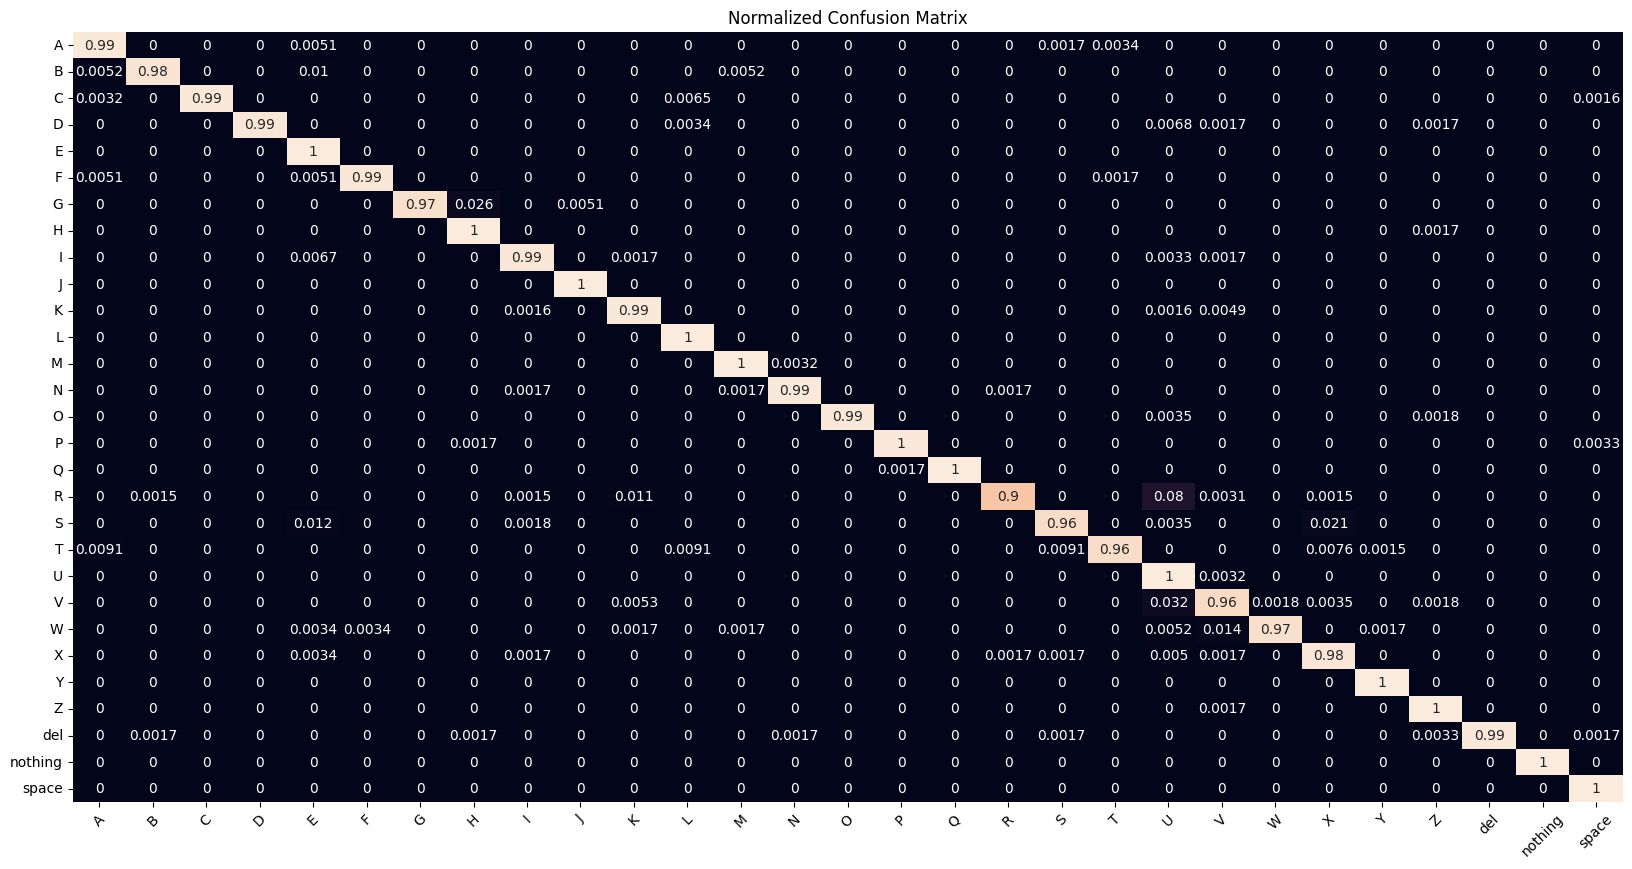

In [20]:
# find accuracy score
acc = accuracy_score(y_true, y_pred)

# class names
class_indices = test_images.class_indices
class_names = [k for k,v in class_indices.items()]

# Display the results
print(f'Best Model: {best_model_name} with {acc*100:.2f}% accuracy on the test set')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# plot confusion matrix
plt.figure(figsize = (20,10))

sns.heatmap(cm, annot=True, xticklabels = sorted(set(class_names)), yticklabels = sorted(set(class_names)), cbar = False)
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation = 45)

# save the plot as an image file
#plt.savefig('confusion_matrix.png')

plt.show()